In [5]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

warnings.filterwarnings('ignore')

#model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [6]:
stock_df = pd.read_csv('./AAPL.csv', sep=',', index_col='Date')
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-15,175.110001,179.500000,172.309998,179.300003,178.265411,131063300
2021-12-16,179.279999,181.139999,170.750000,172.259995,171.266006,150185800
2021-12-17,169.929993,173.470001,169.690002,171.139999,170.152466,195432700
2021-12-20,168.279999,170.580002,167.460007,169.750000,168.770493,107499100
2021-12-21,171.559998,173.199997,169.119995,172.990005,171.991806,91185900
...,...,...,...,...,...,...
2022-12-09,142.339996,145.570007,140.899994,142.160004,142.160004,76069500
2022-12-12,142.699997,144.500000,141.059998,144.490005,144.490005,70462700
2022-12-13,149.500000,149.970001,144.240005,145.470001,145.470001,93886200


<AxesSubplot: >

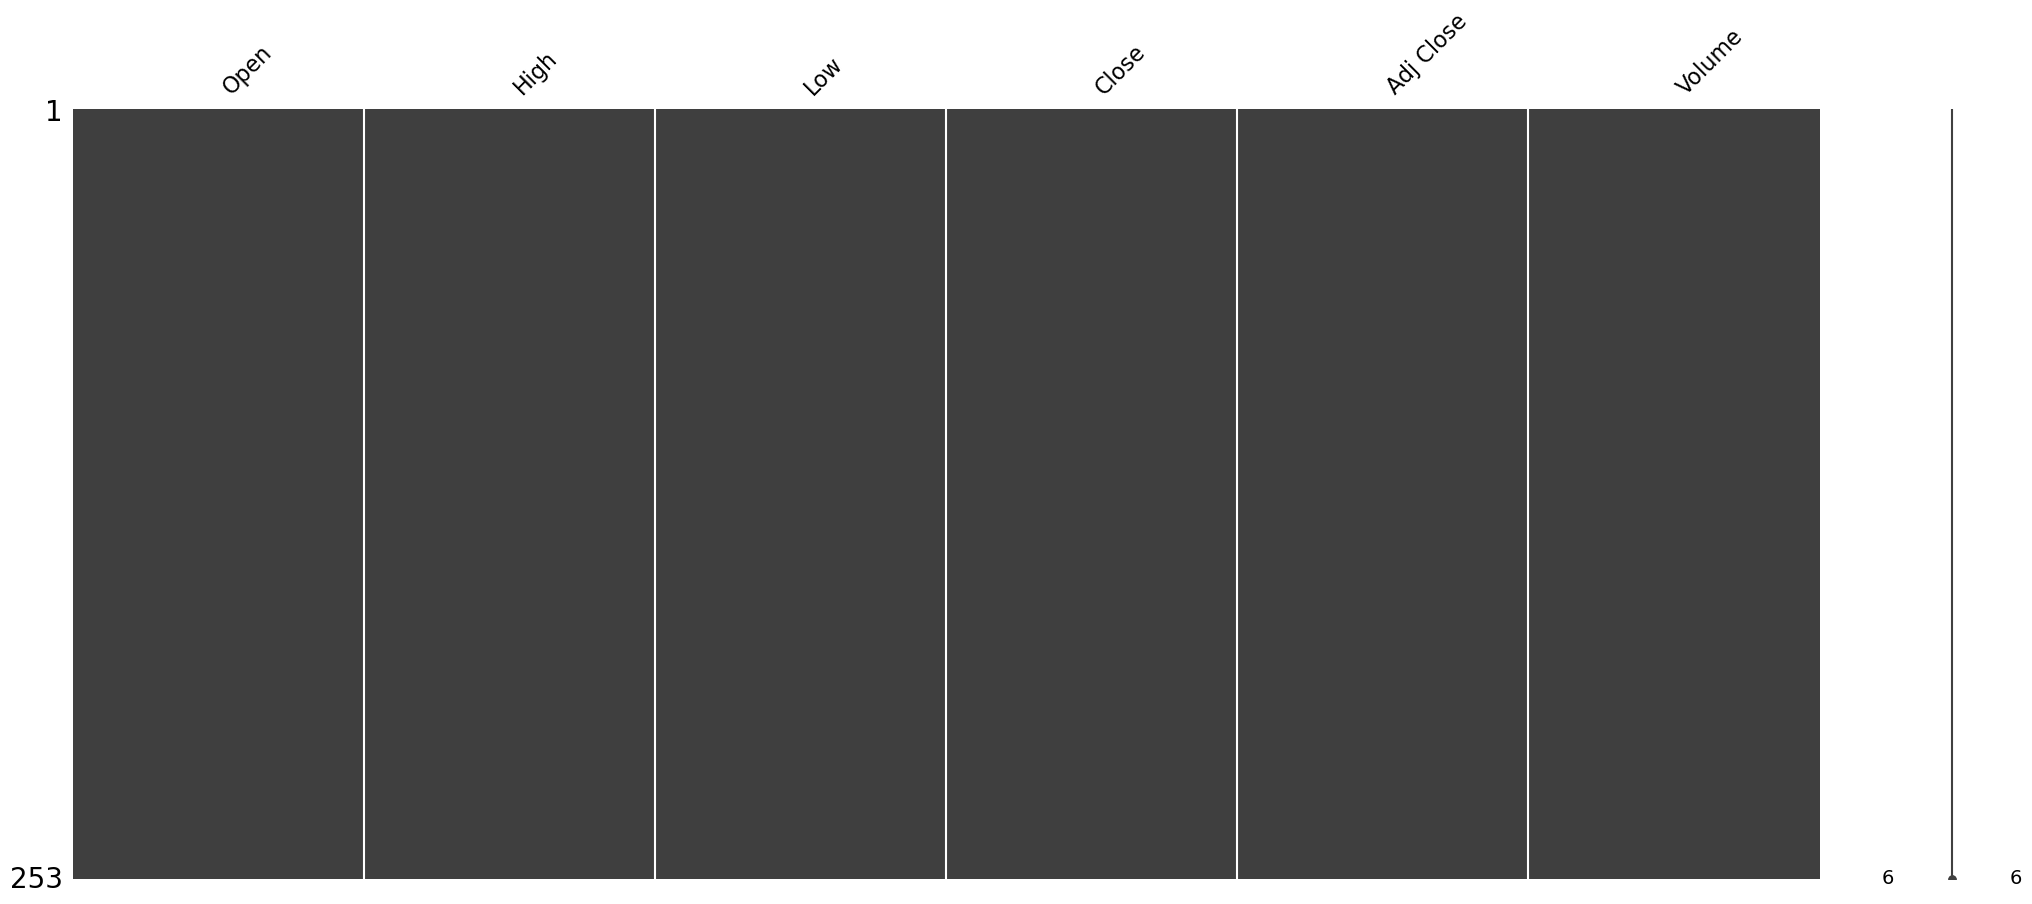

In [7]:
msno.matrix(stock_df)

In [8]:
#stock_df['Date'] = pd.to_datetime(stock_df['Date'])

In [9]:
stock_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [10]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253 entries, 2021-12-15 to 2022-12-15
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  253 non-null    float64
dtypes: float64(1)
memory usage: 4.0+ KB


In [11]:
def check_stationary(ts, alpha):
    print("Dickey Fuller Test ---")
    print("H0: non-stationary")
    print("H1: stationary")
    
    adft = adfuller(ts, autolag='AIC')
    
    if adft[1] < alpha:
        print(f"p-value: {alpha}, reject H0")
    else:
        print(f"p-value: {alpha}, Accept H0")

check_stationary(stock_df['Adj Close'], 0.05)


Dickey Fuller Test ---
H0: non-stationary
H1: stationary
p-value: 0.05, Accept H0


In [12]:
stock_df['Price_diff'] = stock_df["Adj Close"].diff()
stock_df.head()

,Adj Close,Price_diff
Date,,
2021-12-15,178.265411,NaN
2021-12-16,171.266006,-6.999405
2021-12-17,170.152466,-1.113540
2021-12-20,168.770493,-1.381973
2021-12-21,171.991806,3.221313


In [13]:
stock_df.dropna(subset='Price_diff', inplace=True)

In [14]:
check_stationary(stock_df['Price_diff'], 0.05)

Dickey Fuller Test ---
H0: non-stationary
H1: stationary
p-value: 0.05, reject H0


# 모델 진단
- 잔차(Residual) = 실제값 - 예측값
- $e_t = y_t - \hat{y}_t$ 
-  $e_t \sim N(0, \sigma^2)$
 - 잔차는 정규분포를 띄며, 잔차의 평균은 0이고, 분산은 상수를 가짐
 - 잔차끼리 상관관계(correlation)가 없어야 함 

In [15]:
y_train = stock_df['Adj Close'][:int(0.7*len(stock_df))]
y_test = stock_df['Adj Close'][int(0.7*len(stock_df)):]

In [16]:
model_autoARIMA = auto_arima(
    y_train, 
    start_p=0, start_q=0,  # p, q 시작값
    max_p=3, max_q=3,      # p and q 최댓값
    test='adf',            # adf를 통해 d 계산
    d=1,                   # 모델을 통해 d 지정
    m=1,                   # 연(year)간 데이터
    seasonal=False,        # 계절성 없음
    trace=True,            # 값 보여줌
    with_intercept='auto', # 상수 자동으로 포함/비포함 결정
    stepwise=True          # p, q 조합으로 진행
)
model_autoARIMA.fit(y_train)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=914.312, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=916.309, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=916.308, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=912.368, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=918.252, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.122 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -455.184
Date:                Fri, 16 Dec 2022   AIC                            912.368
Time:                        18:19:41   BIC                            915.532
Sample:                             0   HQIC                           913.651
                                - 176                                         
Co

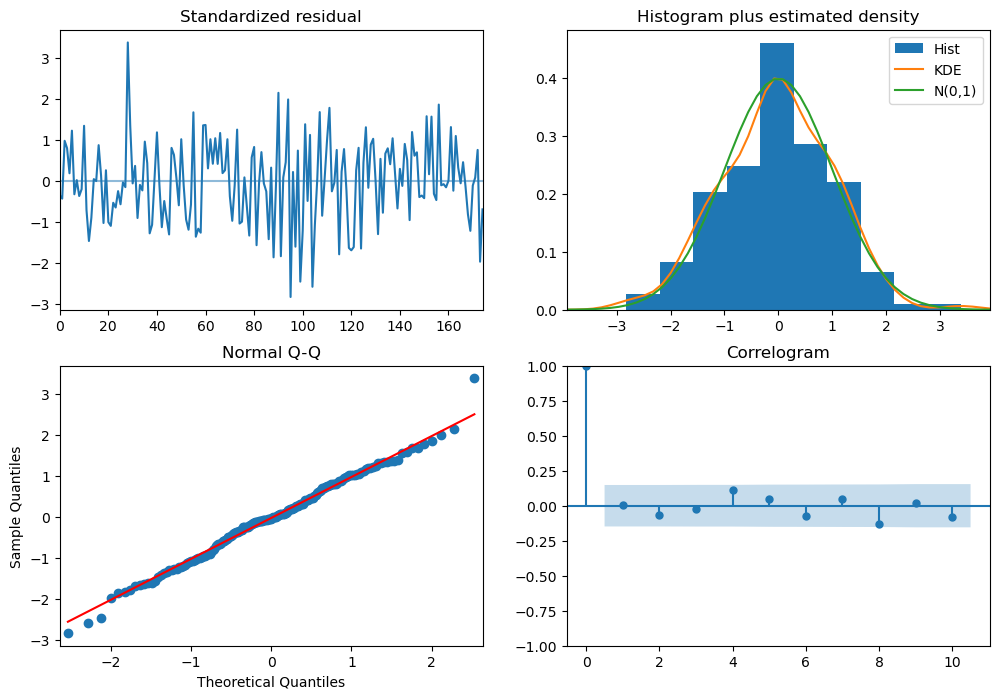

In [17]:
model_autoARIMA.plot_diagnostics(figsize=(12,8))
plt.show()

- **Standardized Residual Plot** (표준화 잔차): 잔차의 표준오차로 나누어 표준화(standardized)한 값을 그래프로 표현한 것으로 평균 0과 분산이 상수인지 확인
- **Histogram plus estimated density** (잔차의 히스토그램): 잔차가 평균 0을 가진 정규분포를 따르는지 확인 
- **Normal Q-Q** (정규 확률 그래프): 이론적 분포인 잔차가 정규분포를 따르는지 확인하는 그래프
- **Correlogram** (ACF plot): 잔차의 상관관계는 lag이 0을 제외하고 (0은 본인과 본인 값이므로 상관관계는 언제나 1) 상관관계 값이 0과 가까우므로 상관관계가 없음. 

In [18]:
y_pred = model_autoARIMA.predict(n_periods=len(y_test))
y_pred

176    161.112747
177    161.112747
178    161.112747
179    161.112747
180    161.112747
          ...    
247    161.112747
248    161.112747
249    161.112747
250    161.112747
251    161.112747
Length: 76, dtype: float64

In [19]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [22]:
rmse(y_test, y_pred)

nan

In [ ]:
def forecast_one_step():
    fc, conf_int = model_autoARIMA.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [ ]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model_autoARIMA.update(new_ob)

In [ ]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-01-28,83329.710938,85435.144509
2021-01-29,81637.226563,83540.358298
2021-02-01,82632.804688,81829.389694
2021-02-02,84026.609375,82824.967819
2021-02-03,84225.726563,84218.772506
...,...,...
2021-05-12,80000.000000,81344.994892
2021-05-13,78500.000000,80140.376574
2021-05-14,80100.000000,78635.751186


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 1.049
